# RAM usage

Estimate RAM usage of `emg3d` as a function of model size.

In [1]:
import emg3d
import numpy as np
import matplotlib.pyplot as plt

%load_ext memory_profiler

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.matplotlib.rcParams['figure.dpi'] = 300
plt.matplotlib.rcParams['savefig.dpi'] = 300

In [3]:
def get_field_and_model_size(grid):
    """Estimate size of fields and model parameters."""

    # 8 Byte per float.
    nbytes = 8

    # Size of electric field, source field, and residual field (MB):
    size_fields = grid.nE*nbytes*2  # 2x because complex
    size_fields *= 3                # efield, sfield, pfield

    # Size of model parameters (MB); isotropic case:
    size_params = grid.nC*nbytes
    size_params *= 4  # res (1x), mu (1x), eta (x2 because complex)
    
    total_size = size_fields + size_params
    
    return total_size/1e6  # => MB
    
def calculate(nx):

    # Grid
    hx = np.ones(nx)*50
    x0 = -nx//2*50
    grid = emg3d.utils.TensorMesh([hx, hx, hx], x0=(x0, x0, x0))

    # Source location and frequency
    src = [0, 0, 0, 0, 0] 
    freq = 1.0
    
    total_size = get_field_and_model_size(grid)
    
    # Model and source field
    model = emg3d.utils.Model(grid, 1., freq=freq)
    sfield = emg3d.utils.get_source_field(grid, src, freq=freq, strength=0)

    # Calculate the field
    efield = emg3d.solver.solver(grid, model, sfield, maxit=1, verb=1)
    
    return total_size

In [4]:
nsizes = np.array([64, 96, 128, 192, 256, 320])
run_mem = np.zeros(nsizes.shape)
dat_mem = np.zeros(nsizes.shape)

for i, nx in enumerate(nsizes):
    mem = %memit -r 1 -o -q total_size = calculate(nx)
           
    run_mem[i] = mem.mem_usage[0]
    dat_mem[i] = total_size
    
    print(f"  == {nx}^3 ~ {nx**3:4.2e} cells ==\n")
    print(f"  RAM req. for data: {total_size:5.0f} MB")
    print(f"  RAM used by MG:    {mem.mem_usage[0]:5.0f} MB\n")
    print(f"  Factor: {mem.mem_usage[0]/total_size:6.2f}\n")

  == 64^3 ~ 2.62e+05 cells ==

  RAM req. for data:    47 MB
  RAM used by MG:      230 MB

  Factor:   4.87

  == 96^3 ~ 8.85e+05 cells ==

  RAM req. for data:   158 MB
  RAM used by MG:      401 MB

  Factor:   2.53

  == 128^3 ~ 2.10e+06 cells ==

  RAM req. for data:   374 MB
  RAM used by MG:      708 MB

  Factor:   1.89

  == 192^3 ~ 7.08e+06 cells ==

  RAM req. for data:  1256 MB
  RAM used by MG:     1838 MB

  Factor:   1.46

  == 256^3 ~ 1.68e+07 cells ==

  RAM req. for data:  2972 MB
  RAM used by MG:     4052 MB

  Factor:   1.36

  == 320^3 ~ 3.28e+07 cells ==

  RAM req. for data:  5797 MB
  RAM used by MG:     7728 MB

  Factor:   1.33



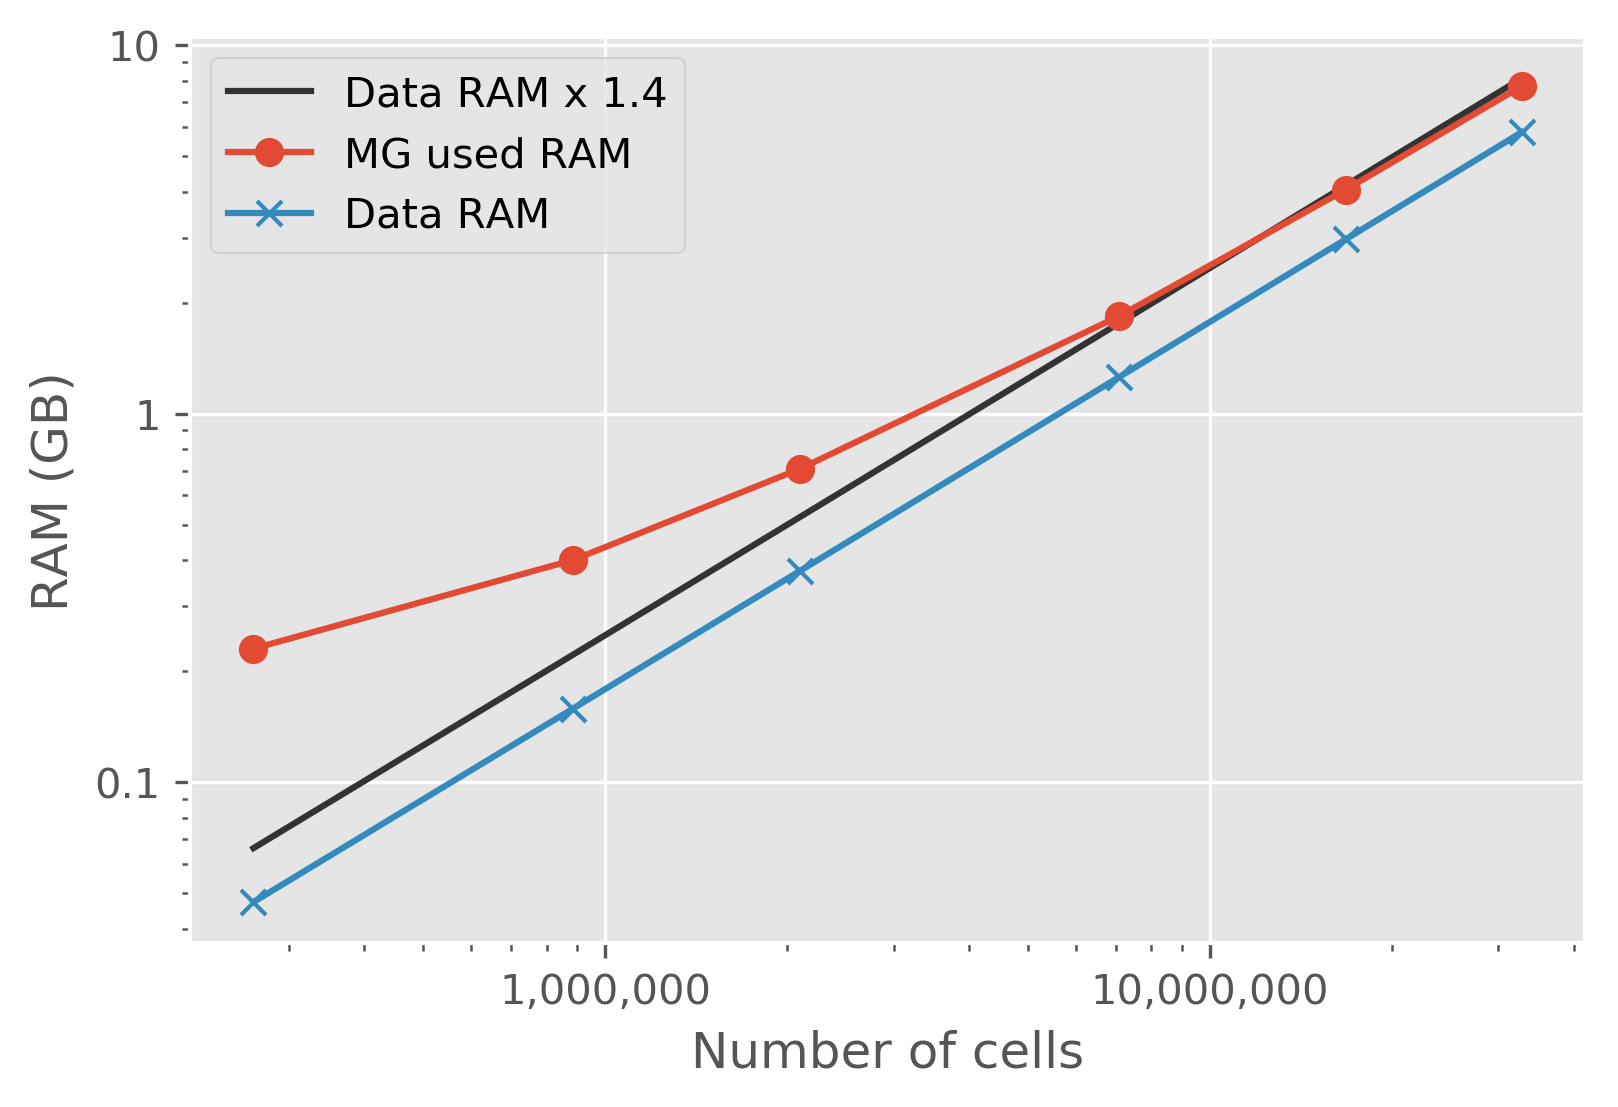

In [7]:
plt.figure()
plt.loglog(nsizes**3, 1.4*dat_mem/1e3, '.2', label='Data RAM x 1.4')
plt.loglog(nsizes**3, run_mem/1e3, 'o-', label='MG used RAM')
plt.loglog(nsizes**3, dat_mem/1e3, 'x-', label='Data RAM')
plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('RAM (GB)')
plt.xticks([1e6, 1e7], ('1,000,000', '10,000,000'))
plt.yticks([1e-1, 1e0, 1e1], ('0.1', '1', '10'))
plt.savefig('RAM-Usage.png', facecolor='none', edgecolor='none', bbox_inches='tight')
plt.show()

In [6]:
emg3d.Versions()

------------------------------------------------------
  Mon Jun 03 14:41:14 2019 CEST

          Linux : OS
              4 : CPU(s)
         1.16.2 : numpy
          1.2.1 : scipy
         0.43.1 : numba
      0.6.2dev0 : emg3d
          7.4.0 : IPython
          3.0.3 : matplotlib

  3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC
  7.3.0]

  Intel(R) Math Kernel Library Version 2019.0.3
  Product Build 20190125 for Intel(R) 64
  architecture applications
------------------------------------------------------